# Originality Algo

## Algorithm to Automate Originality Scoring

### Import Packages

In [77]:
import nltk
import pandas as pd
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
import re
from functools import reduce
import openpyxl
import xlsxwriter

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.util import ngrams
from nltk import ngrams, FreqDist
from nltk.lm import NgramCounter
import string
import gensim
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors

from spacy.lang.en.stop_words import STOP_WORDS

from collections import Counter
import itertools

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer

from nltk.cluster.kmeans import KMeansClusterer

### Put Data from Excel Sheet into Dataframes

In [116]:
# individual df's for each sheet

# when on pc
data_cup = pd.read_csv("C:/Users/jhec8/Documents/Northwestern_SROP/AUT-Scoring/data/autdata_test_cup_semdis.csv")
data_key = pd.read_csv("C:/Users/jhec8/Documents/Northwestern_SROP/AUT-Scoring/data/autdata_test_key_semdis.csv")
data_rope = pd.read_csv("C:/Users/jhec8/Documents/Northwestern_SROP/AUT-Scoring/data/autdata_test_rope_semdis.csv")
data_brick = pd.read_csv("C:/Users/jhec8/Documents/Northwestern_SROP/AUT-Scoring/data/autdata_test_brick_semdis.csv")
data_chair = pd.read_csv("C:/Users/jhec8/Documents/Northwestern_SROP/AUT-Scoring/data/autdata_test_chair_semdis.csv")
data_pencil = pd.read_csv("C:/Users/jhec8/Documents/Northwestern_SROP/AUT-Scoring/data/autdata_test_pencil_semdis.csv")
data_shoe = pd.read_csv("C:/Users/jhec8/Documents/Northwestern_SROP/AUT-Scoring/data/autdata_test_shoe_semdis.csv")

# when on mac
# data_cup = pd.read_csv("/Users/johnhenrycruz/Desktop/Northwestern_SROP/AUT-Scoring/data/autdata_test_cup_semdis.csv.xlsx")
# data_key = pd.read_csv("/Users/johnhenrycruz/Desktop/Northwestern_SROP/AUT-Scoring/data/autdata_test_key_semdis.csv.xlsx")
# data_rope = pd.read_csv("/Users/johnhenrycruz/Desktop/Northwestern_SROP/AUT-Scoring/data/autdata_test_rope_semdis.csv.xlsx")
# data_brick = pd.read_csv("/Users/johnhenrycruz/Desktop/Northwestern_SROP/AUT-Scoring/data/autdata_test_brick_semdis.csv.xlsx")
# data_chair = pd.read_csv("/Users/johnhenrycruz/Desktop/Northwestern_SROP/AUT-Scoring/data/autdata_test_chair_semdis.csv.xlsx")
# data_pencil = pd.read_csv("/Users/johnhenrycruz/Desktop/Northwestern_SROP/AUT-Scoring/data/autdata_test_pencil_semdis.csv.xlsx")
# data_shoe = pd.read_csv("/Users/johnhenrycruz/Desktop/Northwestern_SROP/AUT-Scoring/data/autdata_test_shoe_semdis.csv.xlsx")

### Preprocessing

In [3]:
# nltk corpus stop words
stopwords_nltk = stopwords.words('english')
# spacy stop words
stopwords_spacy = STOP_WORDS

In [31]:
# method to clean the responses
def process_text(text, stopwords_list, remove_sw, join_list):
    # tokenize text, lemmanize words, removing punctuation, remove stop words, lowercase all words

    # hardcorded for special situations
    text = re.sub("wedging","wedge", text)
    text = re.sub("exersizing","exercising", text)
    text = re.sub("thrown","throw", text)
    
    text = re.sub("/|-"," ", text)
    text = text.translate(str.maketrans('','',string.punctuation))
    tokens = word_tokenize(text)

    tokens = [w.lower() for w in tokens]
    
    if remove_sw:
        tokens = [word for word in tokens if word not in stopwords_list]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
#         stemmer = PorterStemmer()
#         tokens = [stemmer.stem(t) for t in tokens]

    if join_list:
        tokens = ' '.join(tokens)
 
    return tokens

### General Functions

In [5]:
# method to get a list of participants
def get_id_list(df):
    id_list = df['id'].unique()
    id_list = sorted(id_list)
    return id_list

In [42]:
# method to add a new column
# new column are cleaned responses
def get_cleaned_responses(df, stopwords_list, remove_sw, join_list):
    # id_df = df[df.id == id]
    df_processed = df.copy(deep=True)
    responses = df['response'].tolist()

    # make list of processed responses
    for response in range(len(responses)):
        responses[response] = process_text(responses[response], stopwords_list, remove_sw, join_list)

    # add list as column in df
    df_processed['response_processed'] = responses

    return df_processed

### Word2Vec Models for Embeddings

In [7]:
# load pretrained model
word_model_twitter25 = api.load("glove-twitter-25")

# on pc
# word_model_google = KeyedVectors.load_word2vec_format("C:/Users/jhec8/Documents/Northwestern_SROP/GoogleNews-vectors-negative300.bin", binary=True)

# on mac
# word_model = KeyedVectors.load_word2vec_format("/Users/johnhenrycruz/Desktop/Northwestern_SROP/GoogleNews-vectors-negative300.bin", binary=True)

In [8]:
# create dictionary of counts for each word in model
twitter25_dict = {}
for i in range(len(word_model_twitter25)):
    twitter25_dict[word_model_twitter25.index_to_key[i]] = word_model_twitter25.key_to_index[word_model_twitter25.index_to_key[i]]

In [9]:
# get the frequency of each word in dictionary
total_words = 0
for key in twitter25_dict:
    total_words = total_words + twitter25_dict[key]
    
for key in twitter25_dict:
    twitter25_dict[key] = twitter25_dict[key]/total_words

## Originality Algo 1
### Term Frequency Only

In [43]:
def get_tf_dict(responses):
    cv = CountVectorizer()   
    cv_fit = cv.fit_transform(responses)    
    word_list = cv.get_feature_names()

    # [0] here to get a 1d-array for iteration by the zip function 
    count_list = np.asarray(cv_fit.sum(axis=0))[0]

    tf_dict = dict(zip(word_list, count_list))
    
    total_words = 0
    for key in tf_dict:
        total_words = total_words + tf_dict[key]
        
    for key in tf_dict:
        tf_dict[key] = np.log(1 + tf_dict[key]/total_words)
        
    tf_dict = dict(sorted(tf_dict.items(), key=lambda item: item[1], reverse=True))
                
    return tf_dict

In [44]:
def get_tf_sum(tf_dict, response):
    tf_sum = 0
    for term in range(len(response)):
        tf_sum = tf_sum + tf_dict[response[term]]
        
    if tf_sum == 0:
        tf_sum = np.nan
        
    return tf_sum

In [45]:
def get_tf_sum_list(tf_dict, responses):
    tf_sum_list = []
    
    for response in responses:
        tf_sum_list.append(get_tf_sum(tf_dict, response))
            
    return tf_sum_list

In [46]:
def get_originality_tf_only(df, stopwords_list, remove_sw, join_list):
    originality_rating_df = get_cleaned_responses(df, stopwords_list, remove_sw, join_list)
    responses = originality_rating_df['response_processed'].tolist()
    responses_tokenized = [item for sublist in responses for item in sublist]

    tf_dict = get_tf_dict(responses_tokenized)
    
    tf_sum_list = get_tf_sum_list(tf_dict, responses)

    originality_rating_df['tf_sum'] = tf_sum_list
        
    return originality_rating_df

In [47]:
get_originality_tf_only(data_brick, stopwords_spacy, True, False)

,id,stim,response,response_processed,tf_sum
0,1476,Brick,as a foundation,[foundation],0.010929
1,1476,Brick,as a weapon,[weapon],0.063851
2,1476,Brick,as a bowl,[bowl],0.010929
3,1718,Brick,build a house,"[build, house]",0.147799
4,1718,Brick,break a window,"[break, window]",0.064757
5,1718,Brick,line a fireplace,"[line, fireplace]",0.032669
6,1718,Brick,line a road,"[line, road]",0.043480
7,1691,Brick,build house,"[build, house]",0.147799
8,1691,Brick,break window,"[break, window]",0.064757
9,1691,Brick,weight for workout,"[weight, workout]",0.064418


## Originality Algo 2
### tf-idf scikit-learn
### participant as document

In [49]:
def tfidf_scikit_learn(cleaned_responses):
    tfIdfVectorizer=TfidfVectorizer(use_idf=True)
    tfIdf = tfIdfVectorizer.fit_transform(cleaned_responses)
    df = pd.DataFrame(tfIdf.toarray(), columns=tfIdfVectorizer.get_feature_names())
#     df = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
#     df = df.sort_values('TF-IDF', ascending=False)
    display(df)
    
#     feature_names = tfIdfVectorizer.get_feature_names()
#     for col in tfIdf.nonzero()[1]:
#         print (feature_names[col], ' - ', tfIdf[0, col])

    print(tfIdf)

In [50]:
def get_originality_tfidf_scikit_learn(df, stopwords_list, remove_sw, join_list):
    originality_rating_df = get_cleaned_responses(df, stopwords_list, remove_sw, join_list)
    responses = []
    
    id_list = get_id_list(df)
    
    for participant in id_list:
        temp_df = originality_rating_df.loc[originality_rating_df['id'] == participant]
        temp_list = temp_df['response_processed'].tolist()
        temp_list = ' '.join(temp_list)
        responses.append(temp_list)
        
    print(responses)
    
    tfidf_scikit_learn(responses)   

In [52]:
get_originality_tfidf_scikit_learn(data_brick, stopwords_spacy, True, True)

['foundation weapon bowl', 'house fire pit weapon break sidewalk paint', 'build hit people paperweight', 'build house break window weight workout weight holding wind karate', 'build house use paperweight break prop martial art use step stool', 'build house break window line fireplace line road', 'throw thing smash thing paper weight weight lifting', 'door stop weapon canvas', 'build use weapon throw', 'build throw demolish paperweight', 'build use weapon paperweight anchor small boat combination rope obviously', 'build house hold open door road carve name cooking', 'build thing throw weapon weight hard surface like anvil']


,anchor,anvil,art,boat,bowl,break,build,canvas,carve,combination,...,stop,surface,thing,throw,use,weapon,weight,wind,window,workout
0,0.000000,0.000000,0.000000,0.000000,0.655075,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.376501,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.302181,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.252086,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.277098,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.241237,0.158851,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.535518,0.350145,0.301952,0.350145
4,0.000000,0.000000,0.335437,0.000000,0.000000,0.231103,0.152178,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.513023,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.250556,0.164987,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.313617,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.581787,0.232401,0.000000,0.000000,0.515905,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.570358,0.000000,0.000000,...,0.570358,0.000000,0.000000,0.000000,0.000000,0.327811,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.359153,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.545423,0.605389,0.455002,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.309031,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.469306,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


  (0, 4)	0.655075136305677
  (0, 47)	0.376501170766038
  (0, 15)	0.655075136305677
  (1, 29)	0.43860410751211154
  (1, 37)	0.43860410751211154
  (1, 5)	0.3021814542943412
  (1, 33)	0.43860410751211154
  (1, 13)	0.43860410751211154
  (1, 20)	0.2750363685138143
  (1, 47)	0.2520855255053467
  (2, 31)	0.4208122865191767
  (2, 32)	0.6107919421788647
  (2, 17)	0.6107919421788647
  (2, 6)	0.2770982249189687
  (3, 21)	0.35014528605914114
  (3, 49)	0.35014528605914114
  (3, 19)	0.35014528605914114
  (3, 51)	0.35014528605914114
  (3, 48)	0.535518256916423
  (3, 50)	0.301952473284094
  (3, 6)	0.15885055209572455
  (3, 5)	0.2412367096966542
  (3, 20)	0.21956631568316437
  (4, 41)	0.335436591890706
  (4, 40)	0.335436591890706
  :	:
  (10, 3)	0.3628432626653525
  (10, 38)	0.3628432626653525
  (10, 0)	0.3628432626653525
  (10, 46)	0.277469380986608
  (10, 31)	0.24998512990463073
  (10, 6)	0.1646112482258863
  (10, 47)	0.2085423573981102
  (11, 10)	0.37565386534262213
  (11, 26)	0.37565386534262213
  

## Originality Algo 3
### tf-idf scikit-learn + clustering
### participant as document


### Potential for Flexibility Algo

In [53]:
def tfidf_scikit_learn_clustering(num_clusters, cleaned_responses):
    tfidf_vectorizer=TfidfVectorizer(use_idf=True)
    tfidf = tfidf_vectorizer.fit_transform(cleaned_responses)
#     df = pd.DataFrame(tfIdf.toarray(), columns=tfIdfVectorizer.get_feature_names())
#     df = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
#     df = df.sort_values('TF-IDF', ascending=False)
#     print (df)
    
    number_of_clusters = num_clusters
    kmeans = KMeans(n_clusters = num_clusters).fit(tfidf)
    
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    terms = tfidf_vectorizer.get_feature_names()
    for i in range(number_of_clusters):
        top_ten_words = [terms[ind] for ind in order_centroids[i, :5]]
        print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))
        
    results = pd.DataFrame()
    results['text'] = cleaned_responses
    results['category'] = kmeans.labels_
    
    results_dict = {k: g["text"].tolist() for k,g in results.groupby("category")}
    
    test = pd.DataFrame(list(results_dict.items()),columns = ['category','responses']) 
    display(test)

In [60]:
def get_originality_tfidf_scikit_learn_clustering(df, stopwords_list, num_clusters, remove_sw, join_list):
    originality_rating_df = get_cleaned_responses(df, stopwords_list, remove_sw, join_list)
    responses_split = originality_rating_df['response_processed'].tolist()
    responses = []
    
    id_list = get_id_list(df)
    
    for participant in id_list:
        temp_df = originality_rating_df.loc[originality_rating_df['id'] == participant]
        temp_list = temp_df['response_processed'].tolist()
        temp_list = ' '.join(temp_list)
        responses.append(temp_list)
        
    display(originality_rating_df)
    
    tfidf_scikit_learn_clustering(num_clusters, responses_split)   

In [61]:
get_originality_tfidf_scikit_learn_clustering(data_brick, stopwords_spacy, 15, True, True)

,id,stim,response,response_processed
0,1476,Brick,as a foundation,foundation
1,1476,Brick,as a weapon,weapon
2,1476,Brick,as a bowl,bowl
3,1718,Brick,build a house,build house
4,1718,Brick,break a window,break window
5,1718,Brick,line a fireplace,line fireplace
6,1718,Brick,line a road,line road
7,1691,Brick,build house,build house
8,1691,Brick,break window,break window
9,1691,Brick,weight for workout,weight workout


Cluster 0: build thing workout door lifting
Cluster 1: sidewalk bowl paint canvas cooking
Cluster 2: weapon use throw workout demolish
Cluster 3: paperweight use stool step workout
Cluster 4: break window prop martial art
Cluster 5: throw thing demolish smash workout
Cluster 6: karate workout window like lifting
Cluster 7: road line fireplace workout lifting
Cluster 8: house build workout fire like
Cluster 9: weight workout paper lifting holding
Cluster 10: like anvil surface hard door
Cluster 11: door stop open hold workout
Cluster 12: pit fire workout line lifting
Cluster 13: anchor combination obviously rope small
Cluster 14: foundation workout window like lifting


,category,responses
0,0,"[build, build, build thing, build, build]"
1,1,"[bowl, sidewalk, paint, hit people, canvas, ca..."
2,2,"[weapon, weapon, throw weapon, use weapon, wea..."
3,3,"[paperweight, paperweight, use paperweight, us..."
4,4,"[break window, break window, break, break prop..."
5,5,"[throw demolish, throw thing, smash thing, throw]"
6,6,[karate]
7,7,"[line fireplace, line road, road]"
8,8,"[build house, build house, house, build house,..."
9,9,"[weight workout, weight holding wind, weight, ..."


## Originality Algo 4
### Counter Vectorizer + clustering

In [56]:
def get_cv_freqs_list(df):
    z = 5
    # Work in Progress

In [71]:
def get_counts_vector(num_clusters, responses):
    # initialize CountVectorizer object
    count_vectorizer = CountVectorizer()
    # vectorize the phrases
    word_count = count_vectorizer.fit_transform(responses)
    
    # elbow method to visualize and find out how many clusters to use
    visualizer = KElbowVisualizer(KMeans(), k=(5,35), timings=False)
    visualizer.fit(word_count.toarray())       
    visualizer.show()

    # nltk kmeans cosine distance implementation
    number_of_clusters = num_clusters
    kmeans = KMeansClusterer(number_of_clusters, distance=nltk.cluster.util.cosine_distance, repeats=25, avoid_empty_clusters=True)
    assigned_clusters = kmeans.cluster(word_count.toarray(), assign_clusters=True)

    # scikit-learn euclidean distance implementation
#     kmeans = KMeans(n_clusters = num_clusters).fit(word_count)
        
    # cluster results scikit-learn
    results = pd.DataFrame()
    results['text'] = responses
#     results['category'] = kmeans.labels_
    results['category'] = assigned_clusters
    
    # create dictionary to organize the clusters with their respective phrases
    results_dict = {k: g["text"].tolist() for k,g in results.groupby("category")}
    
    # df of the clusters and the 
    clusters_df = pd.DataFrame(list(results_dict.items()),columns = ['category','responses']) 
    
    return clusters_df

In [101]:
def get_clustered_originality_score(originality_rating_df, column):
    # get cluster df
    clusters_df = get_counts_vector(22, originality_rating_df['response_processed'].tolist())

    # create dictionary out of cluster df
    clusters = dict(zip(clusters_df.category, clusters_df.responses))
        
    # initialize empty dictionary to store the score for a category
    clusters_scores = dict.fromkeys(clusters)
    
    # get the average cosine distance for a cluster
    for key in clusters:
        score = 1.0
        score = (score/len(clusters[key]))/22
        clusters_scores[key] = score
        
    # create dictionary to store a phrase and its new novelty score 
    # new score is the average of the responses in one cluster
    phrase_scores_dict = {}
    for key in clusters:
        for phrase in clusters[key]:
            phrase_scores_dict[phrase] = clusters_scores[key]
            
    # make a list that matches the one in the current dataframe
    # return list to be added to dataframe
    df_phrases_scores_list = [] 
    for phrase in originality_rating_df['response_processed'].tolist():
        df_phrases_scores_list.append(phrase_scores_dict[phrase])
    
    display(clusters_df)
            
    return list(df_phrases_scores_list)

In [129]:
def get_originality_count_vectorizer(df, stopwords_list, remove_sw, join_list):
    originality_rating_df = get_cleaned_responses(df, stopwords_list, remove_sw, join_list)
    responses = originality_rating_df['response_processed'].tolist()
    originality_rating_df = originality_rating_df[originality_rating_df.astype(str)['response_processed'] != '']
    
#     responses_tokenized = [item for sublist in responses for item in sublist]
    
    originality_rating_df['counts_vectorizer_freq'] = get_clustered_originality_score(originality_rating_df, responses)
        
    return originality_rating_df

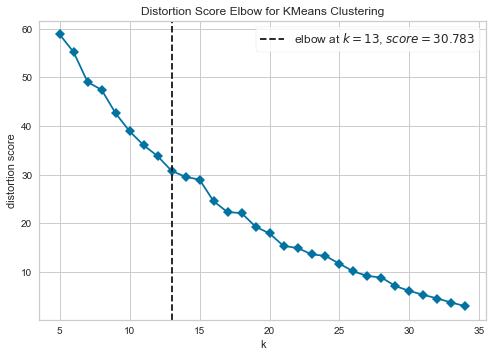

,category,responses
0,0,[break]
1,1,"[build, build, build, build]"
2,2,[sidewalk]
3,3,[karate]
4,5,[house]
5,6,"[paperweight, paperweight, use paperweight, pa..."
6,7,"[weapon, weapon, use weapon, weapon, use weapon]"
7,8,"[foundation, bowl, line fireplace, fire pit, p..."
8,9,"[line road, road]"
9,10,"[throw demolish, throw weapon, throw]"


,id,response,response_nofill,item,item_nofill,SemDis_cbowukwacsubtitle_nf_m,response_processed,counts_vectorizer_freq
0,1476,as a foundation,foundation,Brick,brick,0.77417,foundation,0.005051
1,1476,as a weapon,weapon,Brick,brick,0.85011,weapon,0.009091
2,1476,as a bowl,bowl,Brick,brick,0.82926,bowl,0.005051
3,1718,build a house,build house,Brick,brick,0.93854,build house,0.011364
4,1718,break a window,break window,Brick,brick,0.96992,break window,0.022727
5,1718,line a fireplace,line fireplace,Brick,brick,0.99511,line fireplace,0.005051
6,1718,line a road,line road,Brick,brick,0.99395,line road,0.022727
7,1691,build house,build house,Brick,brick,0.93854,build house,0.011364
8,1691,break window,break window,Brick,brick,0.96992,break window,0.022727
9,1691,weight for workout,weight workout,Brick,brick,1.05438,weight workout,0.009091


In [130]:
get_originality_count_vectorizer(data_brick, stopwords_spacy, True, True)

### Write Results into Excel Sheet

In [131]:
prompts_list = ['cup', 'key', 'rope', 'brick', 'chair', 'pencil', 'shoe']
data_list = [data_cup, data_key, data_rope, data_brick, data_chair, data_pencil, data_shoe]

In [132]:
# write results df of each dataset for specific methods
def write_results_excel(method, stopwords, remove_sw, join_list):
    # change this when writing new sheet
    writer = pd.ExcelWriter('originality_cv_freq_cluster_results.xlsx', engine='xlsxwriter')

    for i in range(len(prompts_list)):
        df = method(data_list[i], stopwords, remove_sw, join_list)
        df.to_excel(writer, sheet_name = prompts_list[i], index = False)
    writer.save()

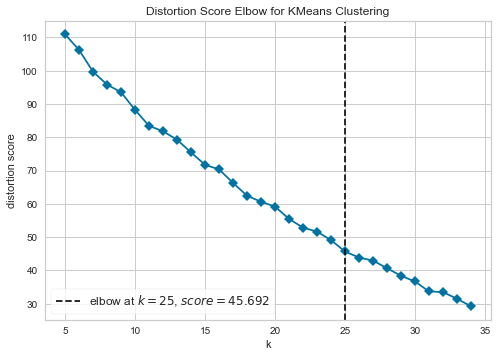

,category,responses
0,0,[throw]
1,1,[bake]
2,2,[cover]
3,3,"[drink, drink, drink, drink, drink, drink, dri..."
4,5,[cook]
5,6,"[stack pyramid, stack]"
6,7,"[hat, boat, act little hat, athletic cup, smas..."
7,8,[drink water]
8,9,[cupping therapy]
9,10,"[pencil holder, pencil holder]"


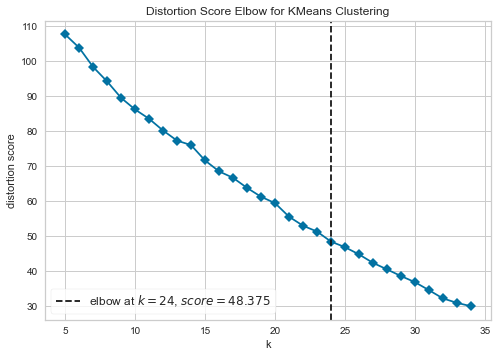

,category,responses
0,0,"[pendant, pendant]"
1,1,[knife]
2,2,"[weapon, weapon, weapon]"
3,4,[break]
4,5,"[necklace, necklace]"
5,6,"[use decoration, decoration, decoration]"
6,7,"[cut open plastic, cut, cut, cut small]"
7,8,"[turn lock, stab, scratch car, chime, gift, st..."
8,9,"[unlock door, unlock door, unlock door, unlock..."
9,10,[wear necklace]


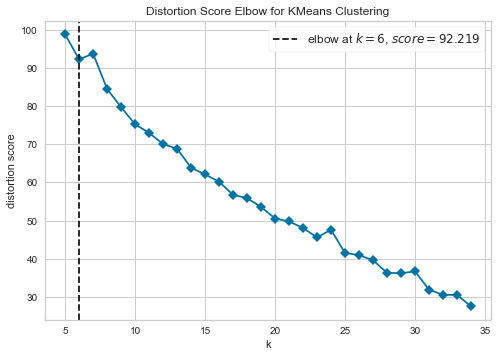

,category,responses
0,0,[group]
1,1,[secure]
2,2,"[climb, climb, climb, climb, climb, climb, cli..."
3,4,[shelter]
4,5,[trip]
5,7,"[swing, catch, help, rescue drowning, holding,..."
6,8,"[tie, tie knot, tie, tie, tie hand, tie shoe, ..."
7,9,"[catching someone lasso, lasso, lasso]"
8,10,"[climbing, rock climbing, rock climb]"
9,11,"[hang self, hang clothes, hang decoration, han..."


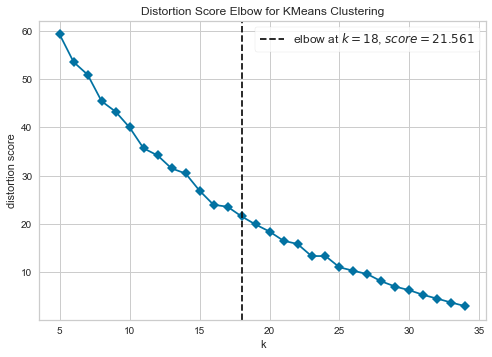

,category,responses
0,0,"[weapon, weapon, weapon]"
1,1,[karate]
2,2,"[paperweight, paperweight, paperweight]"
3,3,[foundation]
4,4,[paint]
5,5,[house]
6,6,"[build, build, build thing, build, build]"
7,7,"[throw demolish, throw]"
8,8,"[bowl, line fireplace, line road, fire pit, si..."
9,9,"[throw thing, smash thing]"


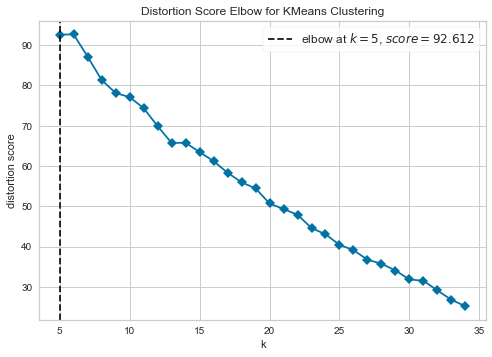

,category,responses
0,0,"[weapon, weapon]"
1,1,[seat]
2,2,[weight]
3,3,"[eat, eat, eat]"
4,4,"[sit, sit, sit, sit, sit, sit, sit, sit, sit, ..."
5,9,"[sitting, sitting]"
6,10,"[stand, stand, stand, stand]"
7,11,"[barricade, barricade door]"
8,12,"[sleep, ladder, obstacle, hit head, rock, stac..."
9,13,"[support pillow fort, pillow, fort]"


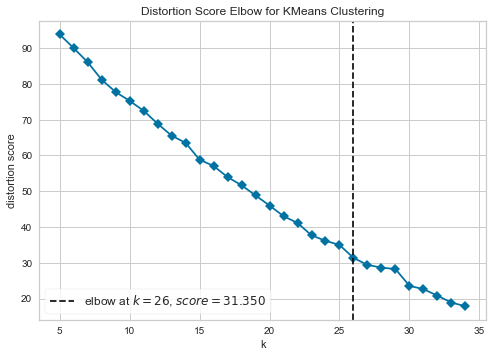

,category,responses
0,0,[drum]
1,1,"[stab, stab, stab]"
2,2,"[write, write, write, write, write, write, wri..."
3,4,[sharpen]
4,6,"[erasing, erasing]"
5,9,[chew]
6,10,[drawing]
7,11,"[click small reset button, erase, twirl, ear, ..."
8,12,[write draw]
9,13,[poke people]


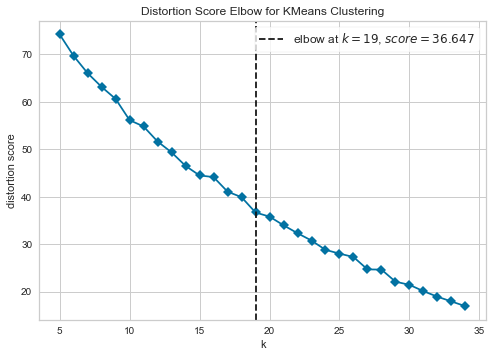

,category,responses
0,0,"[dance, dance]"
1,1,[kick]
2,2,[donating]
3,3,[currency]
4,4,"[weapon, weapon, weapon]"
5,5,[projectile]
6,6,[walk]
7,7,"[piece footwear, tie, fling, plant, fire, exer..."
8,8,"[wear walking, walking, wear, wear]"
9,9,"[hit, hit bug]"


In [133]:
write_results_excel(get_originality_count_vectorizer, stopwords_spacy, True, True)

Algo Design Brainstorming:
* Algo Design w/o scikit-learn
    * asdlfjakl;fjka
    * asdfasf

* Algo Design w/ scikit-learn

* To Do List

